In [47]:
import torch

### Load Analyzed Games

In [48]:
# dataset = torch.load("datasets/dataset_2_games_10_moves.pt")
dataset = torch.load("datasets/dataset_all_games_01.pt")

In [49]:
# dataset = [(white_analysis, black_analysis), (white_elo, black_elo)]
print(len(dataset)) # num of games
print(len(dataset[0][0][0])) # moves of first game (for white)
print(len(dataset[0][0][0][0])) # input size of the model

2000
14
771


### Modify the dataset for training

In [50]:
rating_ranges = [
    (400, 900),
    (900, 1100),
    (1100, 1300),
    (1300, 1500),
    (1500, 1700),
    (1700, 1900),
    (1900, 2100),
    (2100, 2300),
    (2300, 2500),
    (2500, 3000),
]

def calculate_elo_range(elo):
    import scipy.stats as st

    stdv = 100
    return torch.tensor([
            st.norm.cdf(r[1], loc=elo, scale=stdv)
            - st.norm.cdf(r[0], loc=elo, scale=stdv)
            for r in rating_ranges
        ])


def guess_elo_range(elo_range):
    s = 0
    for r, probability in zip(rating_ranges, elo_range):
        s += probability * (r[0] + r[1]) / 2

    return int(s / sum(elo_range))

In [51]:
import random

total_games = len(dataset)
input_size = len(dataset[0][0][0][0])
classes = len(rating_ranges)

test_games = int(total_games * 0.15)

random.shuffle(dataset)

x_train = [torch.stack(game[0]) for game in dataset[:-test_games]]
y_train = [torch.stack([calculate_elo_range(side) for side in game[1]]) for game in dataset[:-test_games]]
x_test  = [torch.stack(game[0]) for game in dataset[-test_games:]]
y_test  = [torch.stack([calculate_elo_range(side) for side in game[1]]) for game in dataset[-test_games:]]

### Define the Model

In [52]:
import torch
from torch import nn, optim

In [53]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X, h0=None, c0=None, train=True):
        # If X is a single sample, add a batch dimension
        if X.dim() == 2:
            X = X.unsqueeze(0)
            
        if c0 is None:
            c0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size)
        if h0 is None:
            h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size)

        out, (hn, cn) = self.lstm(X, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        # CrossEntropyLoss applies the softmax function itself
        # Only apply softmax to get predictions, not training
        if not train:
            out = self.softmax(out)

        return out, (hn, cn)

In [54]:
def initialize_model(input_size, hidden_size, num_layers, num_classes):
    lstm_model = LSTM(input_size, hidden_size, num_layers, num_classes)

    learning_rate = 0.01
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

    loss_func = nn.CrossEntropyLoss()

    return lstm_model, optimizer, loss_func

lstm_model, optimizer, loss_func = initialize_model(input_size, 128, 2, classes)

### Train the model

In [55]:
def train_model(model, optimizer, loss_func, train_data, num_epochs):

    # train_data = [X_train, y_train]
    x_train, y_train = train_data
    # x_train.shape = (batch_size, num_moves, input_size)
    # y_train.shape = (batch_size, 1)

    total_games = len(x_train)
    validation_games = int(total_games * 0.1)

    x_val = x_train[-validation_games:]
    y_val = y_train[-validation_games:]

    x_train = x_train[:-validation_games]
    y_train = y_train[:-validation_games]

    batch_size = len(x_train[0])
    
    loss_per_epoch = []

    for epoch in range(num_epochs):
        for batch, (x_game, y_game) in enumerate(zip(x_train, y_train)):

            cell_states = torch.zeros(model.num_layers, batch_size, model.hidden_size)
            hidden_states = torch.zeros(model.num_layers, batch_size, model.hidden_size)

            # BATCH GAMES TOGETHER BASED ON NUMBER OF MOVES
            # Will maybe change to transformers later

            propabilities, (_hidden_states, _cell_states) = model(
                x_game, hidden_states, cell_states
            )

            loss = loss_func(propabilities, y_game)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

        cell_states = torch.zeros(model.num_layers, batch_size, model.hidden_size)
        hidden_states = torch.zeros(model.num_layers, batch_size, model.hidden_size)
        loss_sum = sum(
            loss_func(model(x_val[i], cell_states, hidden_states)[0], y_val[i]).item()
            for i in range(validation_games)
        )

        print(f"Epoch: {epoch + 1}, Validation Loss: {loss_sum/validation_games}")

        loss_per_epoch.append(loss_sum / validation_games)

    return loss_per_epoch

In [56]:
loss_graph = train_model(lstm_model, optimizer, loss_func, (x_train, y_train), num_epochs=5)

Epoch: 1, Validation Loss: 2.3241593986435762
Epoch: 2, Validation Loss: 2.2969372050290757
Epoch: 3, Validation Loss: 2.165694995572999
Epoch: 4, Validation Loss: 2.099192770203831
Epoch: 5, Validation Loss: 2.1296160547151612


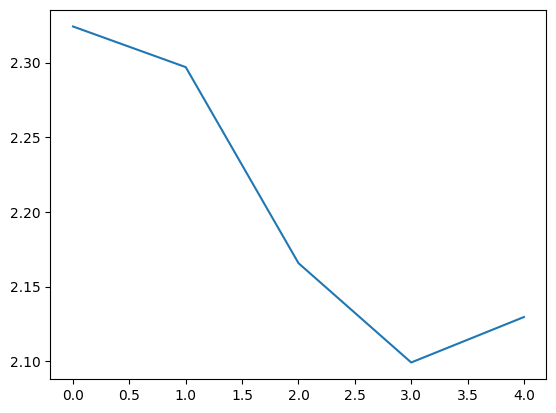

In [57]:
import matplotlib.pyplot as plt
plt.plot(loss_graph)

In [58]:
total_loss = 0

predictions = []
real_values = []
c = 0

for x, y in zip(x_test, y_test):
    out = lstm_model.forward(x[0], train=False)[0]
    loss = loss_func(out, y[0].unsqueeze(0))
    total_loss += loss.item()
    
    predictions.append(guess_elo_range(out[0]))
    real_values.append(guess_elo_range(y[0]))
    if (out[0].argmax() == y[0].argmax()):
        c += 1

    out = lstm_model.forward(x[1], train=False)[0]
    loss = loss_func(out, y[1].unsqueeze(0))
    total_loss += loss.item()
    
    predictions.append(guess_elo_range(out[0]))
    real_values.append(guess_elo_range(y[1]))

    if out[0].argmax() == y[1].argmax():
        c += 1
    
print(f"Average Loss: {total_loss / (len(x_test) * 2)}")
print(f"Correct range guesses: {c} / {len(x_test) * 2} = ({c / (len(x_test) * 2):.2f})")

Average Loss: 2.2669008100494117
Correct range guesses: 88 / 600 = (0.15)


In [63]:

def rate_predictions(predictions, real_values):
    correct = 0
    leeway = 200
    for prediction, real in zip(predictions, real_values):
        if real - leeway <= prediction <= real + leeway:
            correct += 1
    return correct / len(predictions)

percentage = rate_predictions(predictions, real_values)
print(f"Correctly predicted {percentage * 100:.2f}% of games")
print(f"{int(len(predictions) * percentage)} out of {len(predictions)} predictions")

Correctly predicted 31.17% of games
187 out of 600 predictions
